Trying out remove negatives on the finished SEDs.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d
from scipy.io.idl import readsav

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime
from specutils import Spectrum1D
import specutils.manipulation

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [14]:
path = '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/'

In [15]:
specs = glob.glob('{}*var*'.format(path))
specs

['/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj649_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj1132_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj15a_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj163_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj674_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj676a_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj699_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj729_broadb

In [16]:
def remove_negatives(w, f, e):
    print(len(f))
    wo, fo, eo = w, f, e
    nz = len(fo[fo <=0.0])
    print(nz)
    while nz > 0:
        fn = []
        wn = []
        en = []
        inds = []
        for i in range(len(fo))[1:-1]:
            if fo[i] <= 0.0:
                inds.append(i-1)
                inds.append(i+1)
                weights = 1 / (eo[i-1:i+2]**2)
                fn.append(np.average(fo[i-1:i+2],weights=weights))
                wn.append(np.mean(wo[i-1:i+2]))
                en.append((1 / np.sum(weights, axis=0))**0.5)
            else:
                wn.append(wo[i])
                fn.append(fo[i])
                en.append(eo[i])
        inds = np.unique(inds)
        wn, fn, en = np.array(wn), np.array(fn), np.array(en)
        print(len(fn))
        wn, fn, en  = np.delete(wn, inds), np.delete(fn, inds), np.delete(en, inds)
        print(len(fn))
        nz = len(fn[fn <=0.0])
        wo, fo, eo =wn, fn, en
        print(nz)
    return(wn, fn, en)

GJ649
1187383
9911


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:412: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


1187381
1171723
0


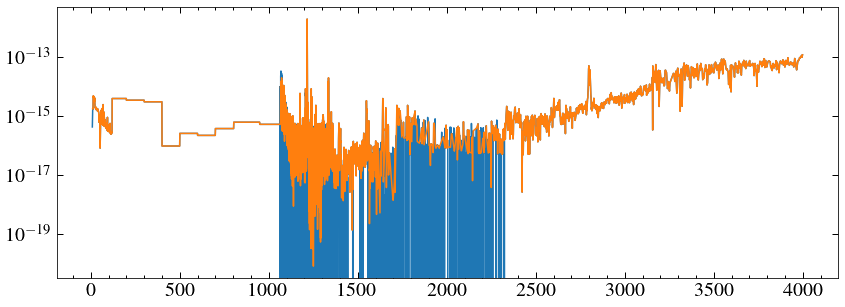

In [17]:
stars = []


for j, spec in enumerate(specs[0:1]):
#     print(spec)
#     plt.figure(figsize = (4*len(doublets), 10))
#     gs = GridSpec(2, 4)
    data = fits.getdata(spec, 1)
    star = fits.getheader(spec)['TARGNAME']
    print(star)
    stars.append(star)
    w, f, e, inst = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['INSTRUMENT']
    wn, fn, en = remove_negatives(w, f, e)
    plt.plot(w[w< 4000], f[w< 4000])    
    plt.plot(wn[wn< 4000], fn[wn< 4000])
    plt.yscale('log')
    plt.show()
    

In [18]:
# stars = []


# doublets = np.array([[1238.821, 1242.804],[1334.524,1335.709],[1393.755,1402.77],[1548.201,1550.772]])
# all_lines = doublets.flatten()
# names = ['N\,v', 'C\,II', 'Si\,IV', 'C\,IV']
# # dv_guess = np.array(ref_dvs)*u.km/u.s

# for j, spec in enumerate(specs):
# #     print(spec)
#     plt.figure(figsize = (4*len(doublets), 10))
#     gs = GridSpec(2, 4)
#     data = fits.getdata(spec, 1)
#     star = fits.getheader(spec)['TARGNAME']
#     print(star)
#     stars.append(star)
#     w, f, e, inst = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['INSTRUMENT']
#     wn, fn, en = remove_negatives(w, f, e)
#     diffs = np.diff(wn[wn < 5700])
#     print('n ones', len(diffs[diffs >1]))
#     print('int og', np.trapz(f[w < 4000], w[w < 4000]))
#     print('int nw', np.trapz(fn[wn < 4000], wn[wn < 4000]))
    
#     # lines = line_list[(line_list['Likelihood to measure'] == 'High') | (line_list['Likelihood to measure'] == 'Medium')]['Wavelength']

#     smooth =7 


#     for i, lines in enumerate(doublets):
# #         plt.subplot(1, len(doublets) , i+1)
#         plt.subplot(gs[0, i])
#         if i == 0:
#             plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
# #         start, end = lines[0]-5, lines[1]+5
#         mask = (w >= lines[0]-7) & (w <= lines[1]+7)
#         maskn = (wn >= lines[0]-7) & (wn <= lines[1]+7)
#         if np.median(inst[mask]) in [1, 2, 16]:
#             mask = (w >= lines[0]-2) & (w <= lines[1]+2)
#             maskn = (wn >= lines[0]-2) & (wn <= lines[1]+2)
#         wi, fi, ei = w[mask], f[mask], e[mask]
#         wj, fj, ej = wn[maskn], fn[maskn], en[maskn]
#         if np.median(inst[mask]) in [1, 2]:
#             fi = convolve(fi,Box1DKernel(smooth))
#             ei = convolve(ei,Box1DKernel(smooth))/smooth**0.5
#             fj = convolve(fj,Box1DKernel(smooth))
#             ej = convolve(ej,Box1DKernel(smooth))/smooth**0.5
# #         plt.errorbar(wi, fi, yerr =ei, errorevery=5)
# #         plt.errorbar(wj, fj, yerr =ej, errorevery=5)
#         plt.step(wi, fi, where='mid')
#         plt.step(wj, fj, where='mid')
        
#     #         print(std_guess)
    
#     plt.subplot(gs[1, :])
#     plt.plot(w[w< 4000], f[w< 4000])    
#     plt.plot(wn[wn< 4000], fn[wn< 4000])
#     plt.yscale('log')
#     plt.xlabel('Wavelength (\AA)')
    
#     plt.xlim(1100, 3000)
#     plt.tight_layout()
#     plt.subplots_adjust(wspace=0.2, hspace=0.1)
# #     plt.savefig('rv_plots/{}_rv.png'.format(star), dpi=150)
# #     plt.savefig('rv_plots/{}_rv.pdf'.format(star), dpi=150)
#     plt.show()
    
#     #     start += step


In [19]:
line_list = Table.read('../lines/all_linelist.csv')

In [20]:
lines = line_list[(line_list['Likelihood to measure'] == 'High')]['Wavelength']


In [21]:
line_groups = np.array([
    [1174.935,1175.265,1175.592,1175.713,1175.713,1175.989,1176.372],
    [1206.499],
    [1264.737,1265.001],
    [1238.821], 
    [1242.804],
    [1294.543],
    [1298.918],
    [1323.952],
    [1334.524],
    [1335.709],
    [1334.524,1335.709],
    [1393.755],
    [1402.77],
    [1548.201],
    [1550.772],
    [1640.332,1640.345,1640.375,1640.391,1640.474,1640.49,1640.533],
    [1657.268],
    [1656.267,1656.926,1657.008,1657.379,1657.907,1658.122],
    [1670.787],
    [2796.35], 
     [2803.53]], dtype='object')

In [76]:


def remove_negatives(w, f, e, grouped_lines, dv=0):
#     print(len(f))
    wo, fo, eo = w, f, e
   
    nz = len(fo[fo <0.0])
#     print(nz)
    while nz > 0:
        fn = []
        wn = []
        en = []
        inds = []
        mask = make_line_mask(wo, grouped_lines, dv=dv)
        wl, fl, el = wo[mask], fo[mask], eo[mask] #mask out lines in regions that you use to make average, but still check them for <0s
        for i in range(len(fo))[1:-3]:
            if fo[i] < 0.0:
                inds.append(i-1)
                inds.append(i+1)
#                 weights = 1 / (eo[i-1:i+2]**2)
#                 fn.append(np.average(fo[i-1:i+2],weights=weights))
#                 wn.append(np.mean(wo[i-1:i+2]))
                weights = 1 / (el[i-1:i+2]**2)
#                 fn.append(np.average(fl[i-1:i+2],weights=weights))
                fn.append(np.mean(fl[i-1:i+2]))
                wn.append(np.mean(wl[i-1:i+2]))
                en.append((1 / np.sum(weights, axis=0))**0.5)
            else:
                wn.append(wo[i])
                fn.append(fo[i])
                en.append(eo[i])
        inds = np.unique(inds)
        inds = inds[np.argsort(inds)]
        print(inds[-1])
        if inds[-1] == len(wn):
            inds = inds[:-2]
        print(inds[-1])
        wn, fn, en = np.array(wn), np.array(fn), np.array(en)
#         print(len(fn))
        wn, fn, en  = np.delete(wn, inds), np.delete(fn, inds), np.delete(en, inds)
#         print(len(fn))
        nz = len(fn[fn <0.0])
        wo, fo, eo =wn, fn, en
#         print(nz)
    return(wn, fn, en)

def mask_maker(x, pairs, include=True):
    """
    creates a mask for a spectrum that excudes between pairs from an array
    """
    b = pairs[::2]
    r = pairs[1::2]
    C = np.zeros_like(x,dtype='bool')
    for i in range(len(b)):
        C |= (x>b[i])&(x<r[i])
    if include:
        return ~C
    else:
        return C

def make_line_mask(w, grouped_lines, dv=0): 
    """
    makes a list of wavelength ranges to cut
    """
    pairs = []
    for group in grouped_lines:
        group =  dv.to(u.AA, equivalencies=u.doppler_optical(group*u.AA)).value
        pairs.append(min(group)-0.5)    
        pairs.append(max(group)+0.5)
    mask = mask_maker(w, pairs)
    return mask

In [70]:
# print(stars)

GJ649


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


29418
29418
n ones 1708
int og 4.171603488019644e-11
int nw 4.192628663946118e-11
ratio 0.994985204364203


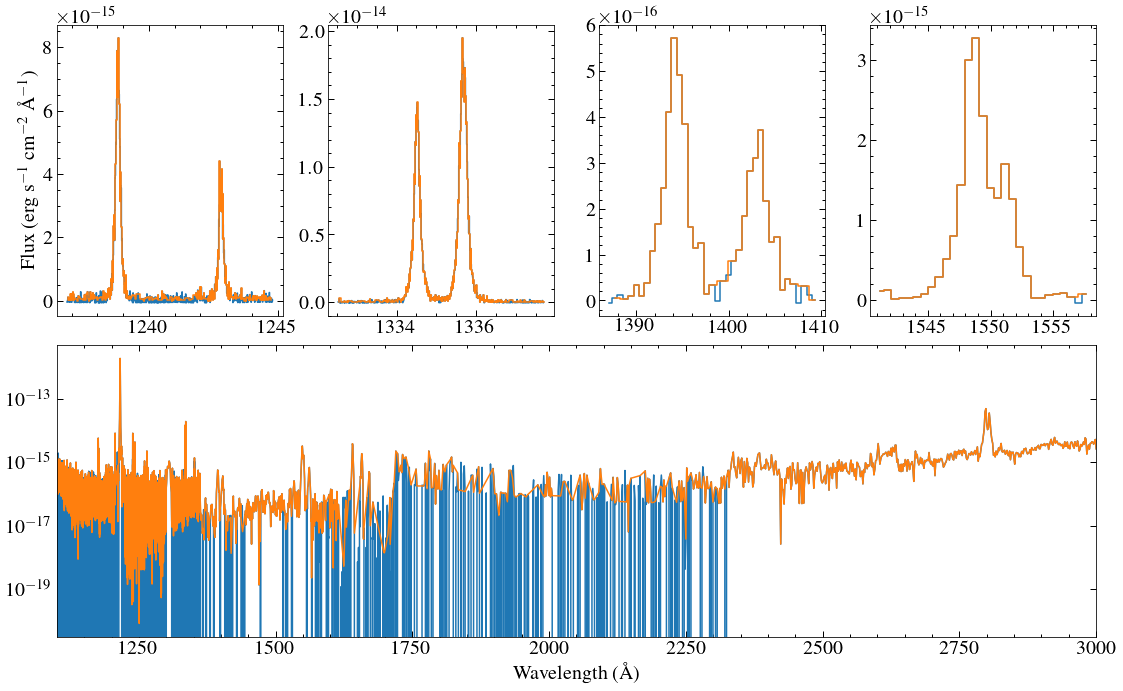

GJ1132


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


59040
59040
n ones 896
int og 1.358098370891653e-12
int nw 1.5366975929247954e-12
ratio 0.883777248786331


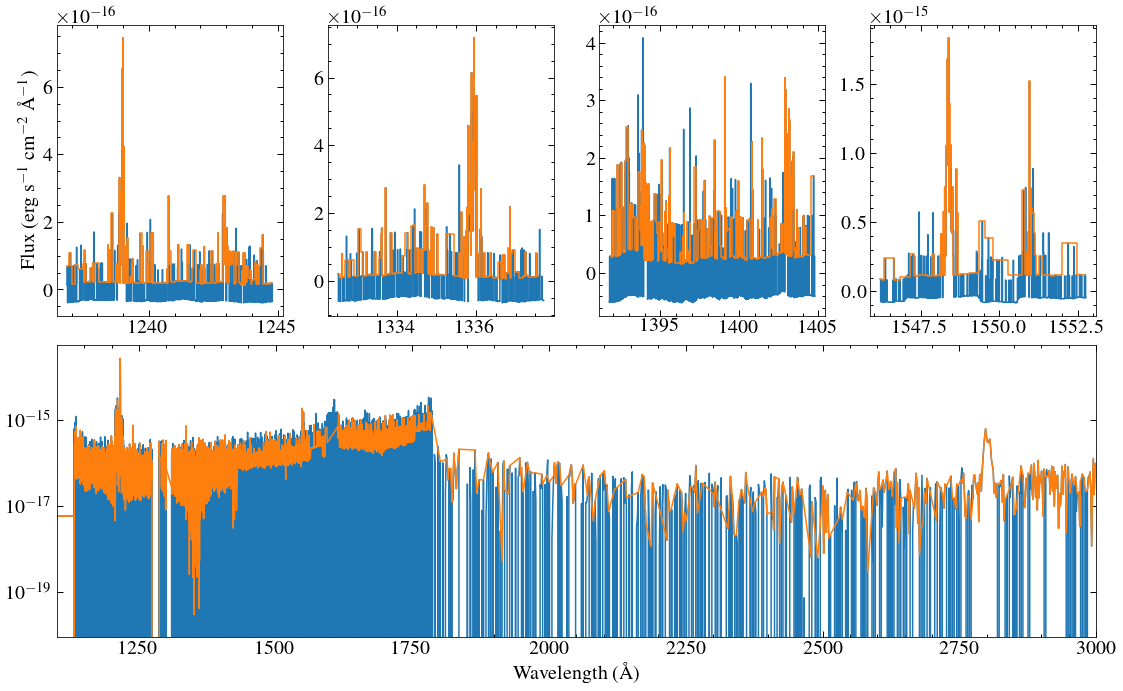

GJ15A


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


38689
38689
n ones 1544
int og 1.578601895405122e-10
int nw 1.7346472773712027e-10
ratio 0.9100420102681843


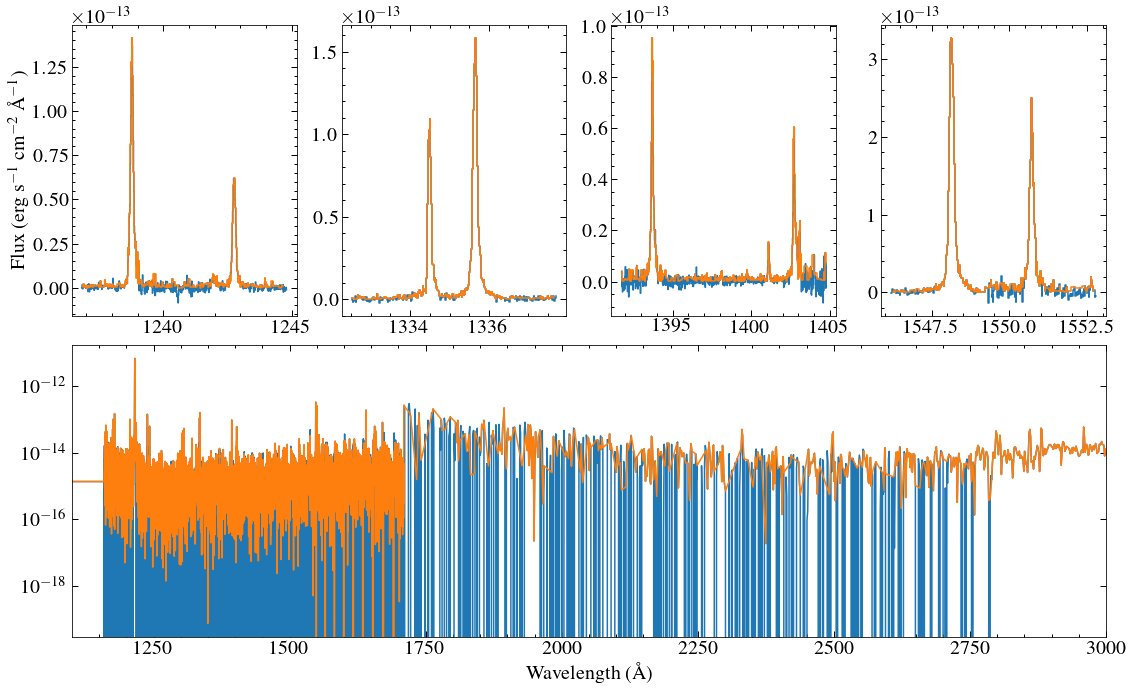

GJ163


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


58782
58782
n ones 1504
int og 6.849077272558882e-12
int nw 6.974652989298975e-12
ratio 0.981995417272693


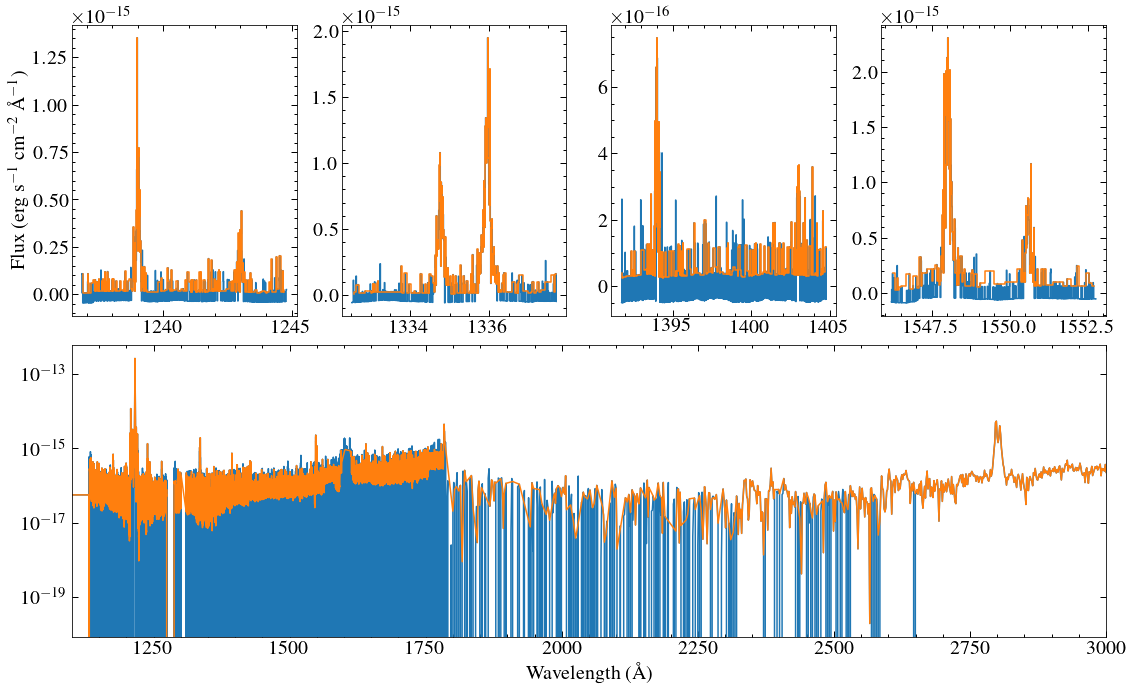

GJ674


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


29425
29425
n ones 1638
int og 5.260802836018257e-11
int nw 5.2863302463018915e-11
ratio 0.995171052678464


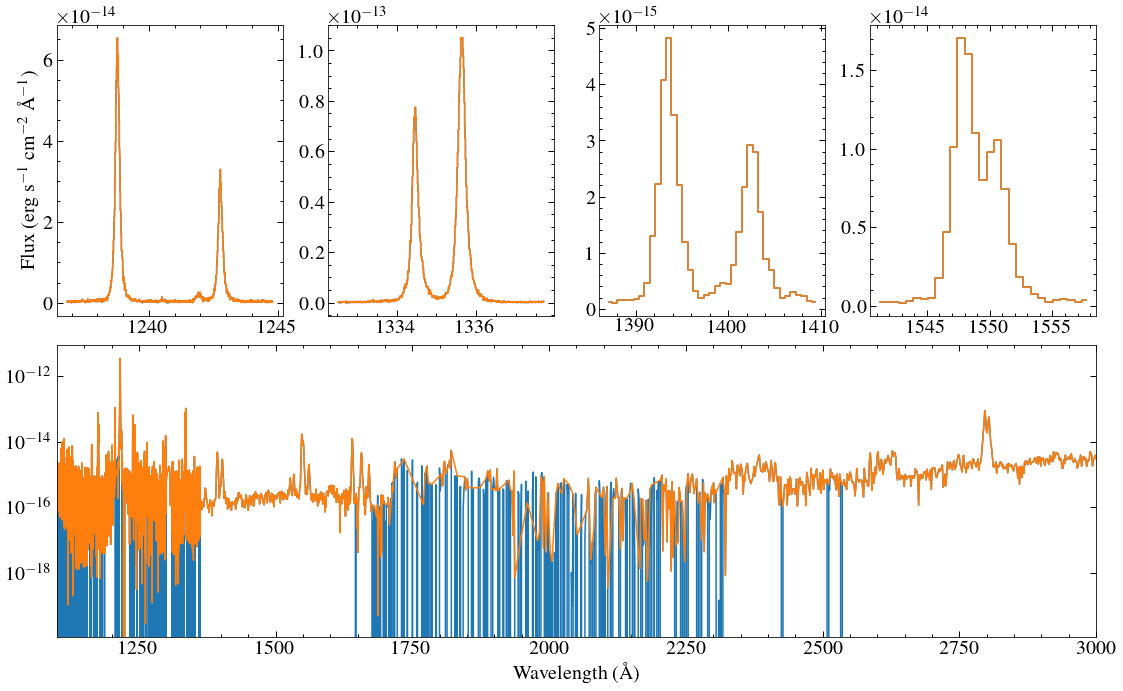

GJ676A


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


29143
29143
n ones 1836
int og 4.4384305855120664e-11
int nw 4.4493010789142905e-11
ratio 0.9975568087640235


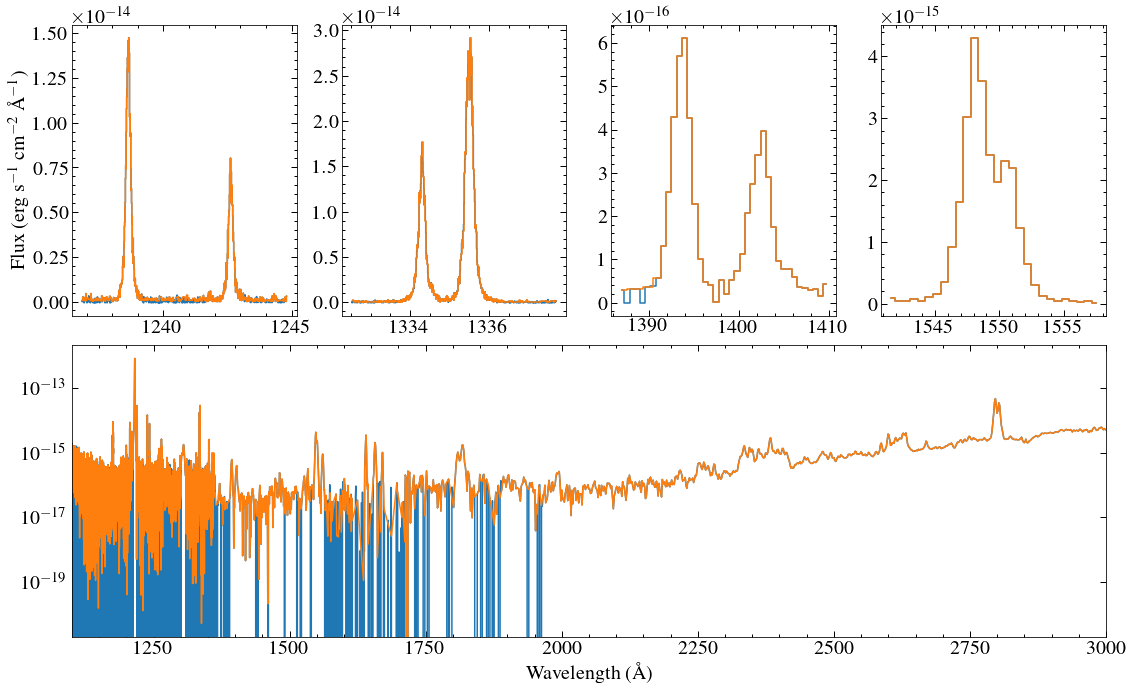

GJ699


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


29932
29932
n ones 1542
int og 3.522128435190675e-11
int nw 3.546625419922156e-11
ratio 0.9930928751049163


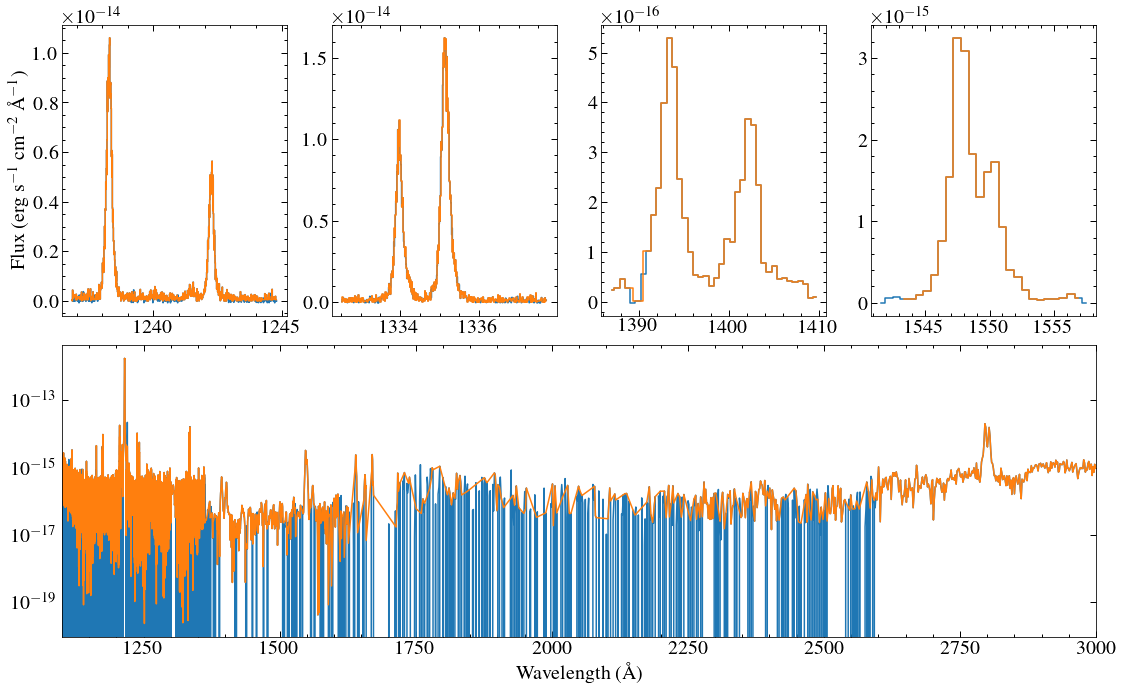

GJ729


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


38944
38944
n ones 1385
int og 3.5870725589843935e-11
int nw 5.0166305276449046e-11
ratio 0.7150362258526486


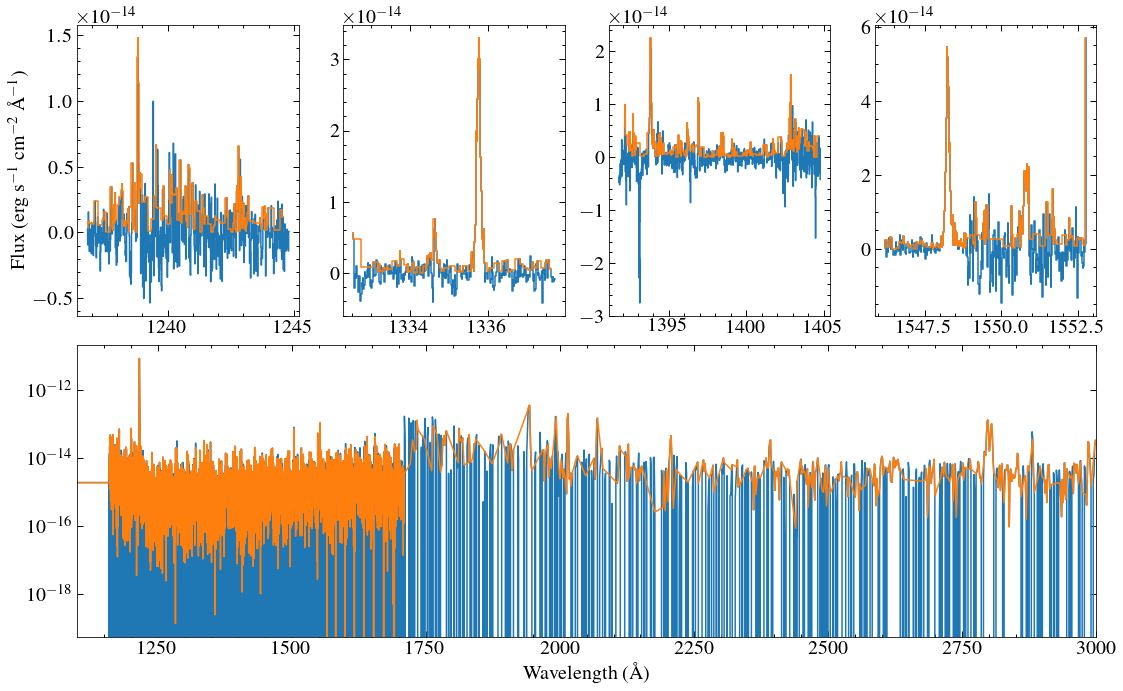

GJ849


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


58436
58436
n ones 1530
int og 2.47115823618757e-11
int nw 2.4919608352758074e-11
ratio 0.991652116360033


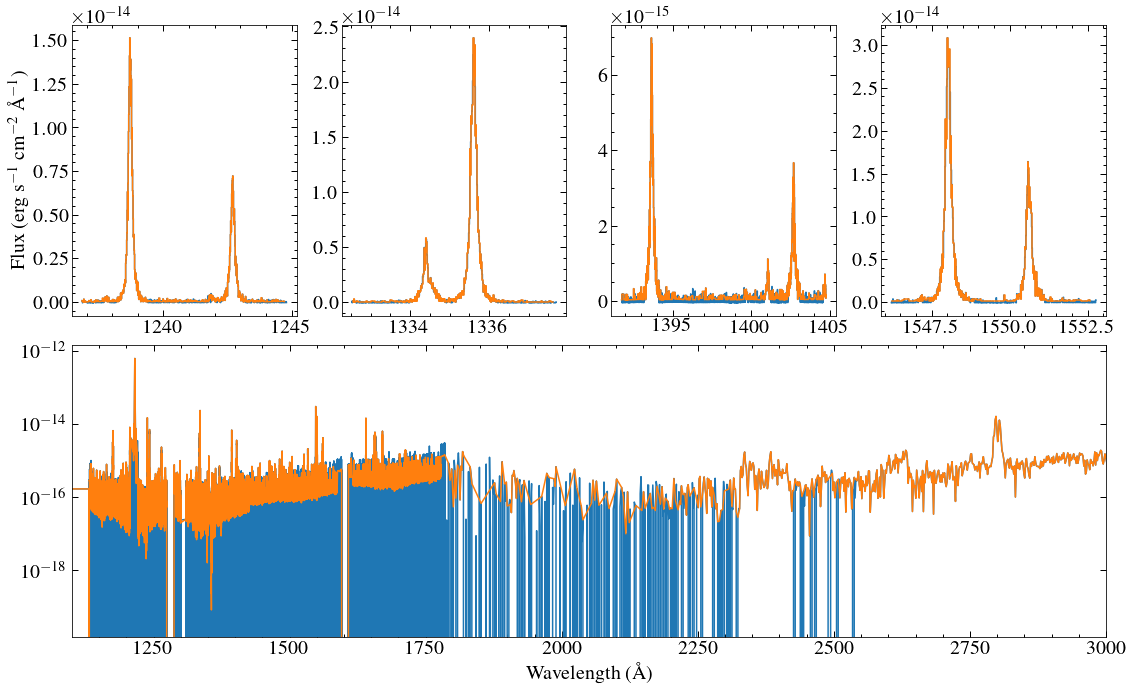

L-980-5


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


52441
52441
n ones 1252
int og 1.8130263052591454e-12
int nw 1.9029883543199815e-12
ratio 0.9527259066737782


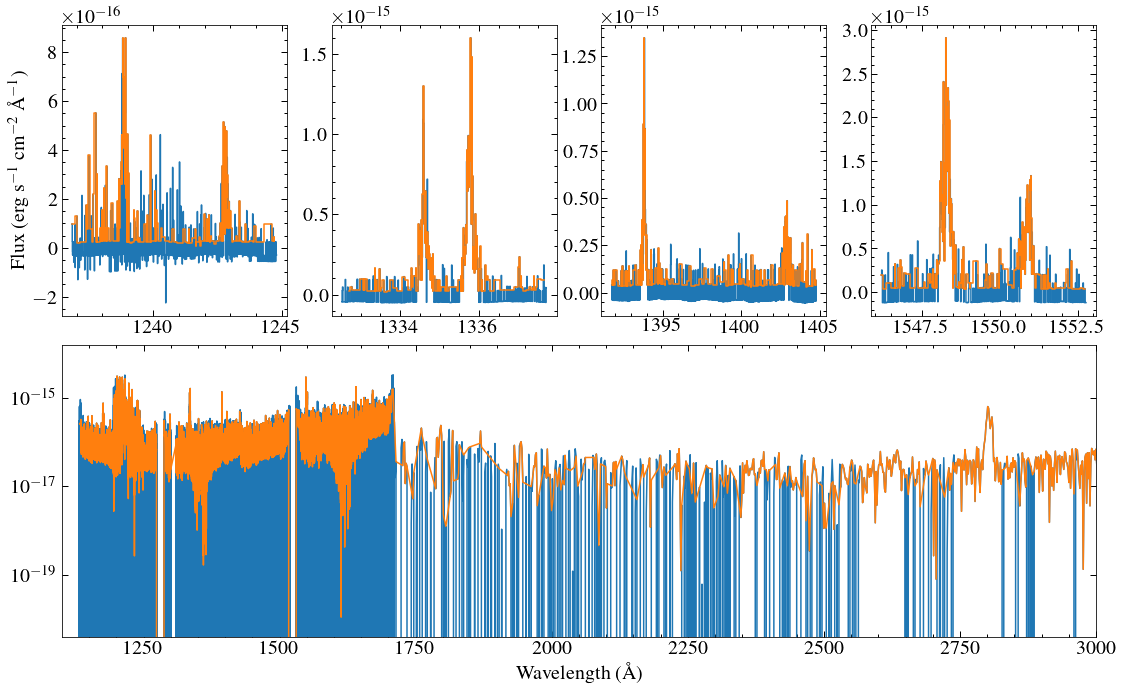

LHS-2686


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


29739
29739
n ones 1826
int og 8.786598112795096e-13
int nw 9.919412683878246e-13
ratio 0.885798221408382


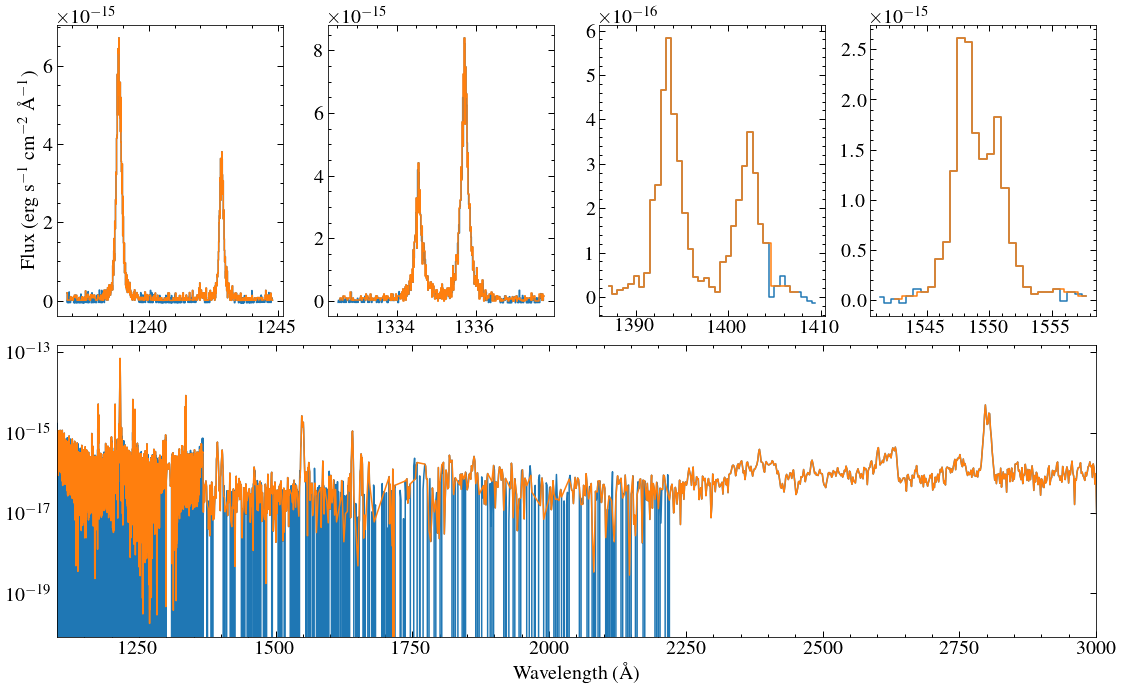

2MASS-J23062928-0502285


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


59888
59888
n ones 1075
int og 2.832275254165363e-13
int nw 5.702455521087943e-13
ratio 0.4966764306519321


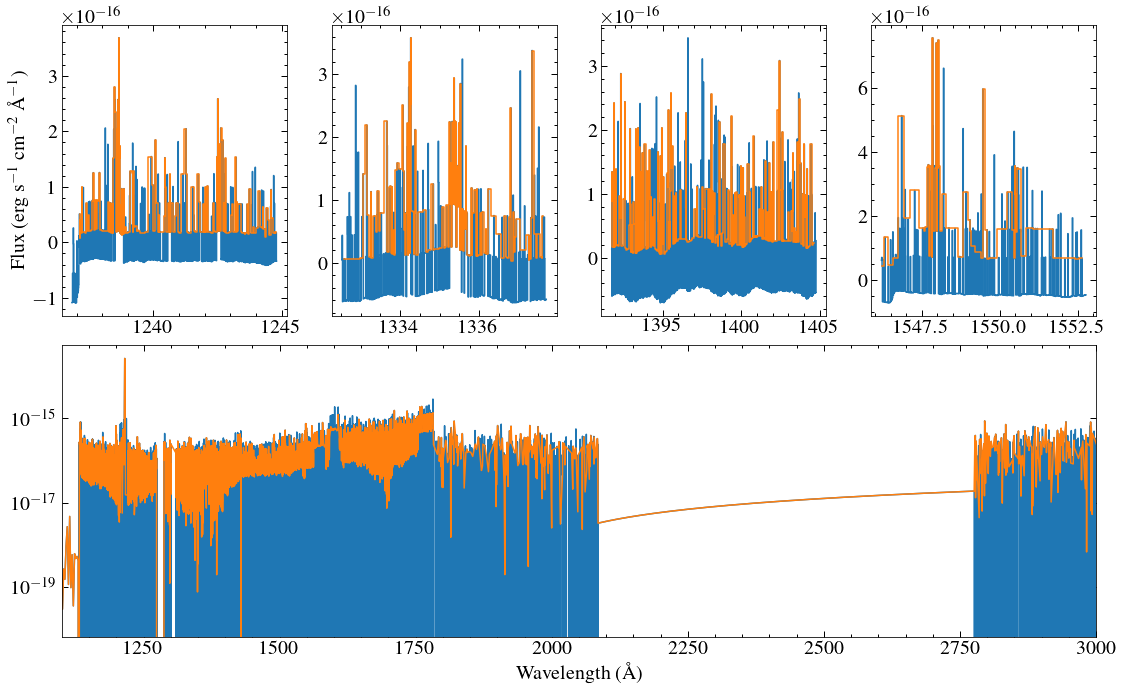

In [92]:
stars = []

dvs = np.array([-3.2179626137386097,  40.08741304111106, -8.29172387532275, 36.44496578836573, 
       -8.496187662426907, -44.461822449302915, -124.3703158406861,12.180515773744279,
      -22.9621644919636, 16.10168084165221, 5.910544014529296,-62.558323075720324])*u.km/u.s


doublets = np.array([[1238.821, 1242.804],[1334.524,1335.709],[1393.755,1402.77],[1548.201,1550.772]])
all_lines = doublets.flatten()
names = ['N\,v', 'C\,II', 'Si\,IV', 'C\,IV']
# dv_guess = np.array(ref_dvs)*u.km/u.s

for j, spec in enumerate(specs):
#     print(spec)
    plt.figure(figsize = (4*len(doublets), 10))
    gs = GridSpec(2, 4)
    data = fits.getdata(spec, 1)
    star = fits.getheader(spec)['TARGNAME']
    print(star)
    stars.append(star)
    w, f, e, inst = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['INSTRUMENT']
    wn, fn, en = remove_negatives(w, f, e, line_groups, dv=dvs[j])
    mask = make_line_mask(w, line_groups, dv=dvs[j])
    wl, fl, el = w[mask], f[mask], e[mask]
    diffs = np.diff(wn[wn < 5700])
    print('n ones', len(diffs[diffs >1]))
    print('int og', np.trapz(f[w < 4000], w[w < 4000]))
    print('int nw', np.trapz(fn[wn < 4000], wn[wn < 4000]))
    print('ratio', np.trapz(f[w < 4000], w[w < 4000])/np.trapz(fn[wn < 4000], wn[wn < 4000]))
    
    # lines = line_list[(line_list['Likelihood to measure'] == 'High') | (line_list['Likelihood to measure'] == 'Medium')]['Wavelength']

    smooth =7 


    for i, lines in enumerate(doublets):
#         plt.subplot(1, len(doublets) , i+1)
        plt.subplot(gs[0, i])
        if i == 0:
            plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
#         start, end = lines[0]-5, lines[1]+5
        mask = (w >= lines[0]-7) & (w <= lines[1]+7)
        maskn = (wn >= lines[0]-7) & (wn <= lines[1]+7)
        maskl = (wl >= lines[0]-7) & (wl <= lines[1]+7)
        if np.median(inst[mask]) in [1, 2, 16]:
            mask = (w >= lines[0]-2) & (w <= lines[1]+2)
            maskn = (wn >= lines[0]-2) & (wn <= lines[1]+2)
            maskl = (wl >= lines[0]-2) & (wl <= lines[1]+2)
            
        wi, fi, ei = w[mask], f[mask], e[mask]
        wj, fj, ej = wn[maskn], fn[maskn], en[maskn]
        wk, fk, ek = wl[maskl], fl[maskl], el[maskl]
#         if np.median(inst[mask]) in [1, 2]:
#             fi = convolve(fi,Box1DKernel(smooth))
#             ei = convolve(ei,Box1DKernel(smooth))/smooth**0.5
#             fj = convolve(fj,Box1DKernel(smooth))
#             ej = convolve(ej,Box1DKernel(smooth))/smooth**0.5
#             fk = convolve(fk,Box1DKernel(smooth))
#             ek = convolve(ek,Box1DKernel(smooth))/smooth**0.5
#         plt.errorbar(wi, fi, yerr =ei, errorevery=5)
#         plt.errorbar(wj, fj, yerr =ej, errorevery=5)
        plt.step(wi, fi, where='mid')
        plt.step(wj, fj, where='mid')
#         plt.step(wk, fk, where='mid')
        
    #         print(std_guess)
    
    plt.subplot(gs[1, :])
    plt.plot(w[w< 4000], f[w< 4000])    
    plt.plot(wn[wn< 4000], fn[wn< 4000])
    plt.yscale('log')
    plt.xlabel('Wavelength (\AA)')
    
    plt.xlim(1100, 3000)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.1)
#     plt.savefig('rv_plots/{}_rv.png'.format(star), dpi=150)
#     plt.savefig('rv_plots/{}_rv.pdf'.format(star), dpi=150)
    plt.show()
    
    #     start += step


Let's make a fake spectrum and test it.

200
143
-0.6346400382798827
194
194
26
1.5724740465654952
194
194
26
1.5724740465654952


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


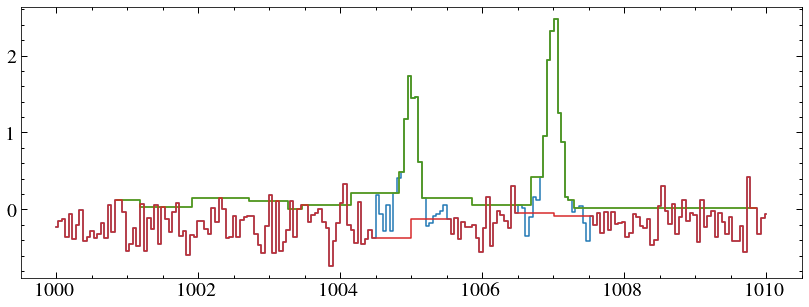

In [79]:

# Generate fake data
np.random.seed(41)
g1 = models.Gaussian1D(2, 1005, 0.1)
g2 = models.Gaussian1D(2.5, 1007, 0.1)
x = np.linspace(1000, 1010, 200)
y = g1(x) + g2(x)+ np.random.normal(-0.17, 0.2, x.shape)
z = np.random.normal(0., 0.2, x.shape)

plt.step(x, y, where='mid')
print(len(y))
print(len(y[y<0]))
print(np.trapz(y,x))
xn, yn, zn = remove_negatives(x, y, z,[[2000]], dv=0*u.km/u.s)

plt.step(xn, yn, where='mid')
print(len(xn))
print(np.trapz(yn,xn))



xn, yn, zn = remove_negatives(x, y, z,[[1005],[1007]], dv=0*u.km/u.s)

plt.step(xn, yn, where='mid')
print(len(xn))
print(np.trapz(yn,xn))


mask = make_line_mask(x, [[1005],[1007]], dv=0*u.km/u.s)
xl, yl, zl = x[mask], y[mask], z[mask]
plt.step(xl, yl, where='mid')

532
532


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


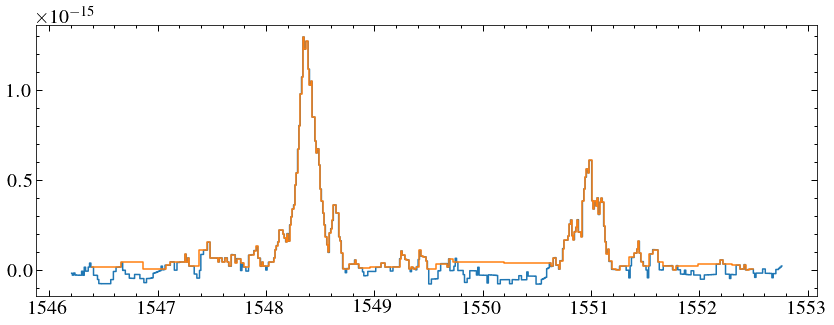

In [90]:
data = fits.getdata(specs[1])
w, f, e, inst = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['INSTRUMENT']
# wn, fn, en = remove_negatives(w, f, e, line_groups, dv=dvs[1])

lines = [1548.201,1550.772]


#         start, end = lines[0]-5, lines[1]+5
# mask = (w >= lines[0]-7) & (w <= lines[1]+7)
# maskn = (wn >= lines[0]-7) & (wn <= lines[1]+7)
# if np.median(inst[mask]) in [1, 2, 16]:
mask = (w >= lines[0]-2) & (w <= lines[1]+2)
#     maskn = (wn >= lines[0]-2) & (wn <= lines[1]+2)

    
    
wi, fi, ei = w[mask], f[mask], e[mask]
fi = convolve(fi,Box1DKernel(smooth))
ei = convolve(ei,Box1DKernel(smooth))/smooth**0.5
wj, fj, ej = remove_negatives(wi, fi, ei, line_groups, dv=dvs[1])

# wj, fj, ej = wn[maskn], fn[maskn], en[maskn]
# if np.median(inst[mask]) in [1, 2]:
#     fi = convolve(fi,Box1DKernel(smooth))
#     ei = convolve(ei,Box1DKernel(smooth))/smooth**0.5
#     fj = convolve(fj,Box1DKernel(smooth))
#     ej = convolve(ej,Box1DKernel(smooth))/smooth**0.5

#         plt.errorbar(wi, fi, yerr =ei, errorevery=5)
#         plt.errorbar(wj, fj, yerr =ej, errorevery=5)
plt.step(wi, fi, where='mid')
plt.step(wj, fj, where='mid')